<a href="https://colab.research.google.com/github/Mehranmollanorozi/Brain-Tumor-Detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mehranmollanorozi","key":"2c000a9cd4bc430afc586ae410d12035"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 771MB/s]


In [ ]:
# استخراج فایل فشرده
!unzip -q brain-mri-images-for-brain-tumor-detection.zip

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
DATA_DIR = '/content/brain_tumor_dataset'
CATEGORIES = ['no', 'yes']  # برچسب‌ها
IMG_SIZE = 224  # اندازه استاندارد برای ورودی مدل

In [ ]:
data = []
for category in CATEGORIES:
    folder_path = os.path.join(DATA_DIR, category)
    class_label = CATEGORIES.index(category)

    for img in tqdm(os.listdir(folder_path), desc=f"Processing {category}"):
        try:
            img_path = os.path.join(folder_path, img)
            img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # تصویر سیاه‌وسفید
            resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
            data.append([resized_arr, class_label])
        except Exception as e:
            print(f"Error loading {img}: {e}")

Processing yes: 100%|██████████| 155/155 [00:00<00:00, 619.10it/s]


In [ ]:
X = []
y = []

for feature, label in data:
    X.append(feature)
    y.append(label)

In [ ]:
# نرمال‌سازی تصاویر و تبدیل به آرایه‌ی NumPy
X = np.array(X) / 255.0  # مقیاس‌گذاری بین ۰ و ۱
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # اضافه کردن channel

y = np.array(y)
y = to_categorical(y, 2)  # تبدیل به one-hot

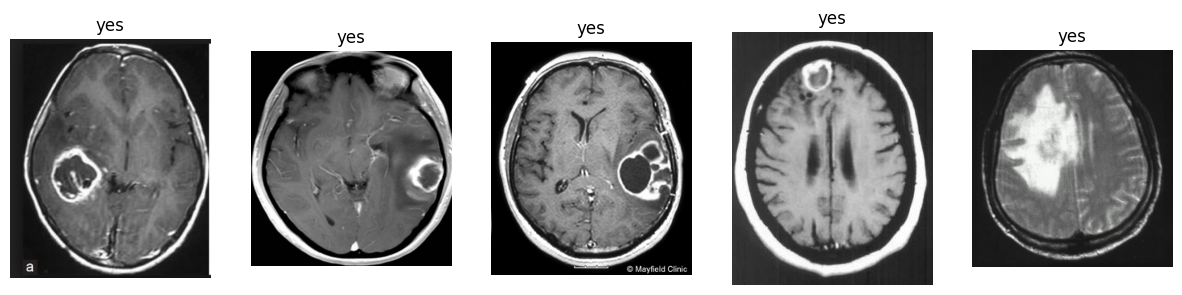

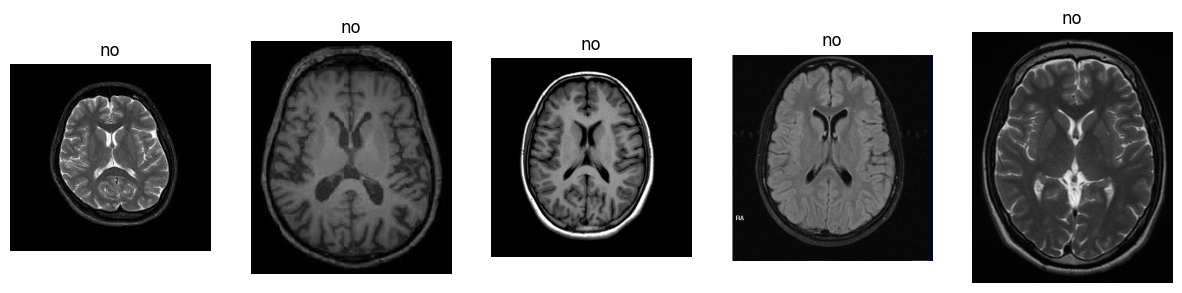

In [ ]:
import matplotlib.pyplot as plt

def show_sample_images(category, num=5):
    folder = os.path.join(DATA_DIR, category)
    images = os.listdir(folder)[:num]

    plt.figure(figsize=(15, 5))
    for i, img in enumerate(images):
        img_path = os.path.join(folder, img)
        img_arr = cv2.imread(img_path)
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num, i + 1)
        plt.imshow(img_arr)
        plt.title(category)
        plt.axis('off')
    plt.show()

# نمایش ۵ نمونه از yes و no
show_sample_images("yes")
show_sample_images("no")


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [ ]:
val_datagen = ImageDataGenerator()

In [ ]:
batch_size = 32

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_test, y_test, batch_size=batch_size)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),  # نیاز به 3 کانال داریم
    include_top=False,
    weights='imagenet'
)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# تکرار 3 کانال برای سازگاری با مدل‌های pretrained
X = np.repeat(X, 3, axis=-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_test, y_test, batch_size=batch_size)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.4963 - loss: 0.8329 - val_accuracy: 0.5686 - val_loss: 0.6912 - learning_rate: 1.0000e-04
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5534 - loss: 0.7824 - val_accuracy: 0.6078 - val_loss: 0.6622 - learning_rate: 1.0000e-04
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6738 - loss: 0.6370 - val_accuracy: 0.6471 - val_loss: 0.5874 - learning_rate: 1.0000e-04
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6410 - loss: 0.6329 - val_accuracy: 0.7647 - val_loss: 0.5270 - learning_rate: 1.0000e-04
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6779 - loss: 0.6569 - val_accuracy: 0.7843 - val_loss: 0.4811 - learning_rate: 1.0000e-04
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7066 - loss: 0.5738 - val_accuracy: 0.7843 - val_loss: 0.4629 - learning_rate: 1.0000e-04
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7768 - loss: 0.4933 - val_

In [ ]:
import random

def show_random_predictions(model, X_test, y_test, class_names=['no', 'yes'], num=3):
    indices = random.sample(range(len(X_test)), num)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        img = X_test[idx]
        true_label = np.argmax(y_test[idx])
        pred = model.predict(np.expand_dims(img, axis=0))[0]
        pred_label = np.argmax(pred)

        plt.subplot(1, num, i + 1)
        plt.imshow(img.astype('float32'))
        plt.title(f"Predicted: {class_names[pred_label]}\nTrue: {class_names[true_label]}")
        plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


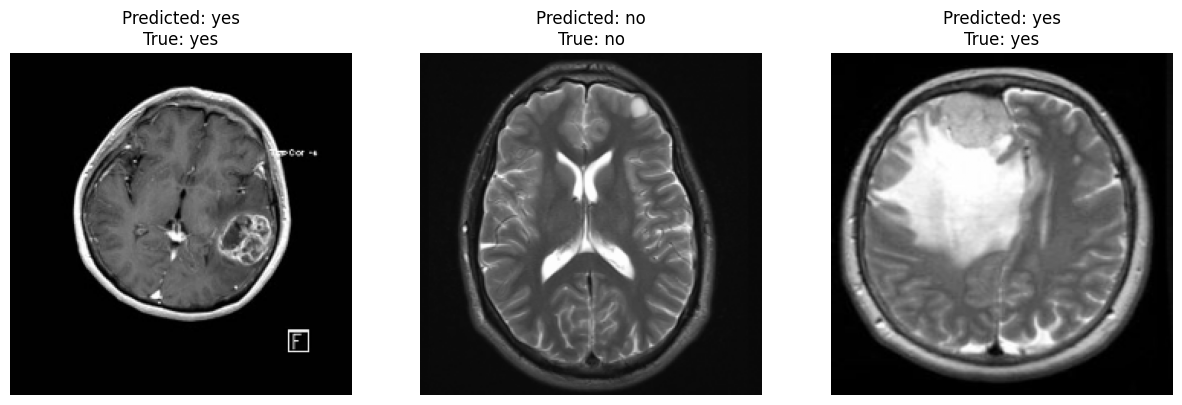

In [ ]:
show_random_predictions(model, X_test, y_test)


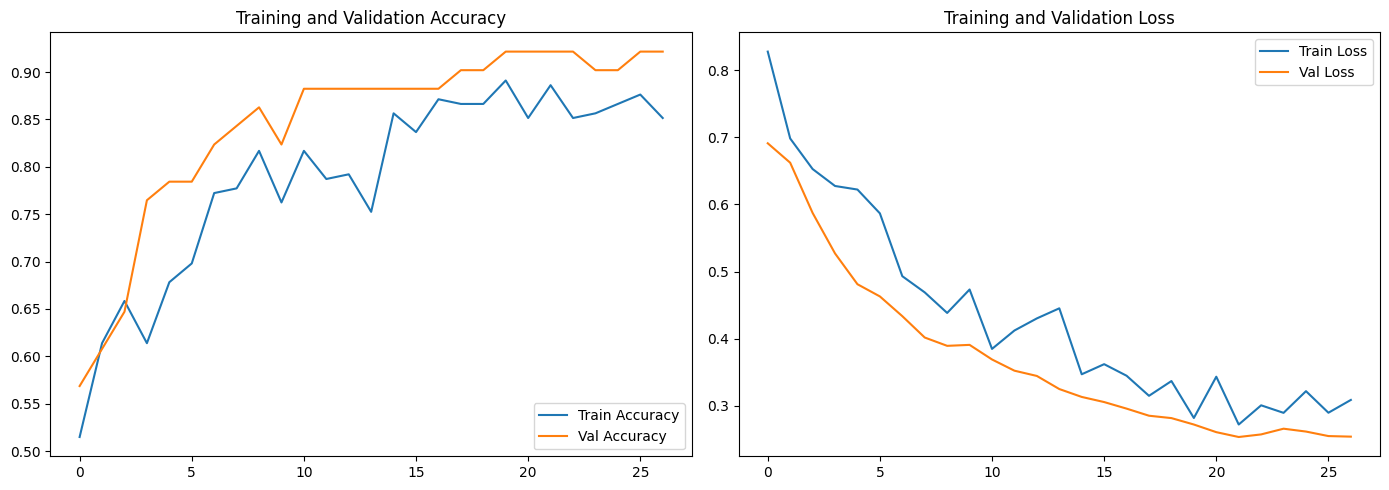

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 675ms/step


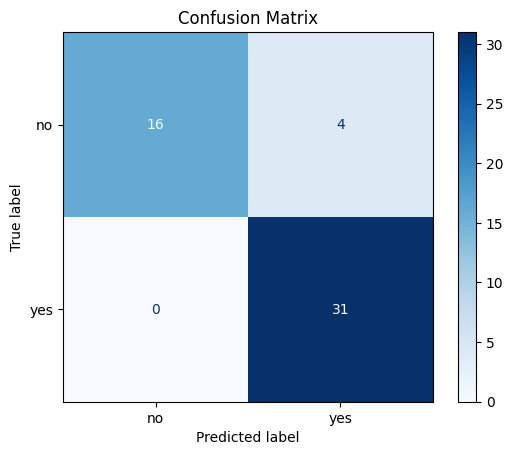

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# پیش‌بینی مدل
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no', 'yes'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       1.00      0.80      0.89        20
         yes       0.89      1.00      0.94        31

    accuracy                           0.92        51
   macro avg       0.94      0.90      0.91        51
weighted avg       0.93      0.92      0.92        51



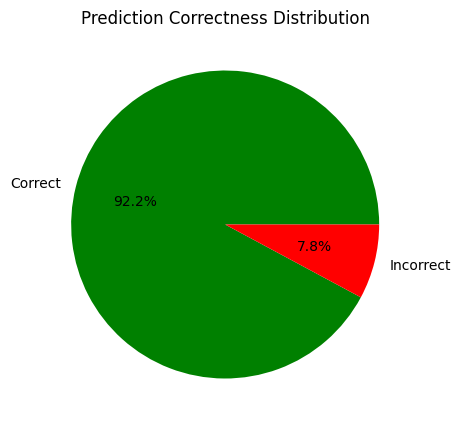

In [ ]:
correct = np.sum(y_pred_classes == y_true)
incorrect = np.sum(y_pred_classes != y_true)

plt.figure(figsize=(5, 5))
plt.pie([correct, incorrect], labels=['Correct', 'Incorrect'], autopct='%1.1f%%', colors=['green', 'red'])
plt.title('Prediction Correctness Distribution')
plt.show()